In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# Carga de datos

In [2]:
# Load dataset
data = pd.read_csv('Maternal Health Risk Data Set.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
data['RiskLevel'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

data['PulsePressure'] = data['SystolicBP'] - data['DiastolicBP']
data['MAP'] = data['DiastolicBP'] + (data['PulsePressure'] / 3)
data['BPRatio'] = data['SystolicBP'] / data['DiastolicBP']

data.drop(columns=(['HeartRate', 'DiastolicBP']), inplace=True)


x = data.drop(columns=['RiskLevel'])
y = data['RiskLevel']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=10)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

/Users/diegolozoya/Documents/ITESO/Semestre 7/ProyectoFinalMIA/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


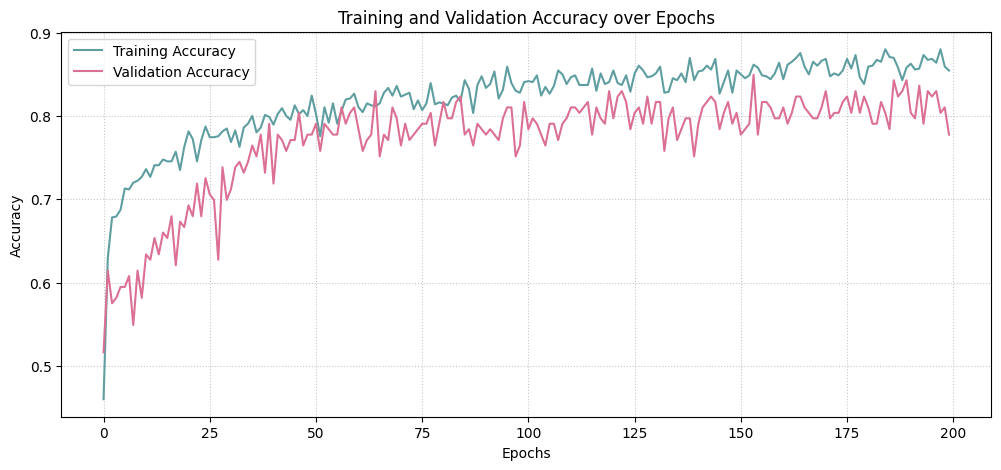

In [4]:
model = tf.keras.Sequential([

    # Layer 1
    tf.keras.layers.Dense(
        128, activation='relu',
        input_shape=(x_train.shape[1],),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.BatchNormalization(),

    # Layer 2
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.BatchNormalization(),

    # Layer 3
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Layer 4
    tf.keras.layers.Dense(
        64, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Layer 5
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
    verbose=0
)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='cadetblue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='palevioletred')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.grid(linestyle=':', alpha=0.7)
plt.show()

In [5]:
y_new_pred_train = model.predict(x_train)
y_new_pred_test = model.predict(x_test)
y_new_pred_train_classes = np.argmax(y_new_pred_train, axis=1)
y_new_pred_test_classes = np.argmax(y_new_pred_test, axis=1)

A = confusion_matrix(y_train, y_new_pred_train_classes)
num_classes = A.shape[0]

TP = np.diag(A)
FP = np.sum(A, axis=0) - TP
FN = np.sum(A, axis=1) - TP
TN = np.sum(A) - (TP + FP + FN)

# Precision: TP / (TP + FP)
precision_per_class = TP / (TP + FP + 1e-12)

# Recall: TP / (TP + FN)
recall_per_class = TP / (TP + FN + 1e-12)

# Accuracy
accuracy = np.sum(TP) / np.sum(A)

# Macro averages
precision_macro = np.mean(precision_per_class)
recall_macro = np.mean(recall_per_class)

print("\n=== TRAIN METRICS ===")
print("Accuracy:", accuracy)

print("\nPrecision per class:", precision_per_class)
print("Macro Precision:", precision_macro)

print("\nRecall per class:", recall_per_class)
print("Macro Recall:", recall_macro)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== TRAIN METRICS ===
Accuracy: 0.8826945412311266

Precision per class: [0.875      0.85018727 0.93162393]
Macro Precision: 0.8856037325138416

Recall per class: [0.9025788  0.80496454 0.94782609]
Macro Recall: 0.8851231408417363


In [6]:
A = confusion_matrix(y_test, y_new_pred_test_classes)
num_classes = A.shape[0]

TP = np.diag(A)
FP = np.sum(A, axis=0) - TP
FN = np.sum(A, axis=1) - TP
TN = np.sum(A) - (TP + FP + FN)

# Precision: TP / (TP + FP)
precision_per_class = TP / (TP + FP + 1e-12)

# Recall: TP / (TP + FN)
recall_per_class = TP / (TP + FN + 1e-12)

# Accuracy
accuracy = np.sum(TP) / np.sum(A)

# Macro averages
precision_macro = np.mean(precision_per_class)
recall_macro = np.mean(recall_per_class)

print("\n=== TEST METRICS ===")
print("Accuracy:", accuracy)

print("\nPrecision per class:", precision_per_class)
print("Macro Precision:", precision_macro)

print("\nRecall per class:", recall_per_class)
print("Macro Recall:", recall_macro)


=== TEST METRICS ===
Accuracy: 0.8496732026143791

Precision per class: [0.8        0.80357143 1.        ]
Macro Precision: 0.8678571428571246

Recall per class: [0.84210526 0.83333333 0.88095238]
Macro Recall: 0.8521303258145192


In [7]:
# model.save('maternal_health_risk_model.keras')

In [8]:
def permutation_importance(model, x_valid, y_valid, metric=accuracy_score):
    baseline = metric(y_valid, np.argmax(model.predict(x_valid), axis=1))
    importances = {}

    for i, col in enumerate(range(x_valid.shape[1])):
        x_temp = x_valid.copy()
        np.random.shuffle(x_temp[:, i]) 

        score = metric(y_valid, np.argmax(model.predict(x_temp), axis=1))
        importances[col] = baseline - score

    return importances
importances = permutation_importance(model, x_test, y_test)
sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
sorted_importances

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{2: 0.39215686274509803,
 0: 0.20261437908496727,
 1: 0.196078431372549,
 4: 0.196078431372549,
 5: 0.1895424836601307,
 6: 0.1633986928104575,
 3: 0.13725490196078427}

In [9]:
x_train_df = pd.DataFrame(x_train, columns=x.columns)
x_test_df = pd.DataFrame(x_test, columns=x.columns)

x_train_df['RiskLevel'] = y_train.values
x_test_df['RiskLevel'] = y_test.values

#x_train_df.to_csv('maternal_health_risk_train.csv', index=False)
#x_test_df.to_csv('maternal_health_risk_test.csv', index=False)